<a href="https://colab.research.google.com/github/david3951445/ML_project/blob/main/FinalProject/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir data # 建立資料夾

In [ ]:
import keras
print(keras.__version__)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(33253, 12)
(33253,)
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   9 out of  18 | elapsed:   18.6s remaining:   18.6s
[Parallel(n_jobs=10)]: Done  18 out of  18 | elapsed:   26.0s finished


Best Params:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 0, 'subsample': 0.7}


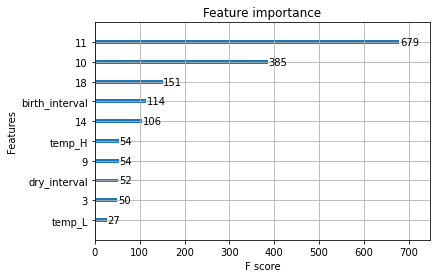

In [3]:
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from pandas.core.reshape.concat import concat
from datetime import datetime
import os 

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats as st
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LSTM
from keras import optimizers
from keras.optimizers import Adam
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ignore warning : This TensorFlow binary is optimized with oneAPI ...
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def main():
    ''' load data '''
    data_report = pd.read_csv('data/report.csv')
    data_submission = pd.read_csv('data/submission.csv')
    data_birth = pd.read_csv('data/birth.csv')
    # data_breed = pd.read_csv('data/breed.csv')
    # data_spec = pd.read_csv('data/spec.csv')
    
    '''
    # Data pre-processing #
    important data : season of calving,  氣候,  泌乳高峰第幾天(dry interval) , stocking  rate
    一開始的六個星期中奶量不斷提高，一直到每日25至60升，然後不斷下降
    
    brith.csv
    COL 2, 3 :
        COL 2 - COL 3(前一胎次) = 乾乳期
    COL 4, 5 : 犢牛1, 犢牛2
        insufficient, drop()
    COL 6 : 母牛體重
    COL 7, 9 : 登錄日期, 胎次 
        repeat, drop()
    COL 8 : 計算胎次
        meaningless, drop()
    COL 10 : 分娩難易度
    COL 11, 12: 犢牛體型, 犢牛性 
        insufficient, drop()
    COL 13 : 酪農場代號
        repeat, drop()
    
    bread.csv
    report.csv
    COL 2 : 年
        drop()
    COL 3 : 月
    x_train.replace([3, 4, 5], 'spring')
    x_train.replace([6, 7, 8], 'summer')
    x_train.replace([9, 10, 11], 'autumn') 
    x_train.replace([12, 1, 2], 'winter')
    COL 4 : 農場代號
    COL 5 : 乳牛編號
    COL 6, 7 : 父、母
        drop()
    COL 8 : 出生日期
        drop()
    COL 9 : 胎次
        反比
    COL 10 : 泌乳天數 (COL 15 - COL 12)
    COL 11 : 乳量
    COL 12 : 最近分娩
        if 19 has value
            分娩間隔 = COL 12 - COL 19
        else
            分娩間隔 = COL 12 - COL 8 # 第一次分娩 - 出生日期
    COL 13 : 採樣日期 (COL 15 - (1day ~ 3day))
        drop()
    COL 14 : 月齡
        反比
    COL 15 : 檢測日期 (年/月 : COL 2 / COL 3)
        drop()
    COL 16 : 最後配種日期 (=受精)
    COL 17 : 最後配種精液
    COL 18 : 配種次數
        反比
    COL 19 : 前次分娩日期
        drop()
    COL 20 : 第一次配種日期
    COL 21 : 第一次配種精液
    spec.csv (health)
 
    '''
    x_train = pd.DataFrame()

    # # COL 3
    temp = data_report.iloc[:, 2]
    temp1 = temp.replace([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2], ['spring', 'spring', 'spring',\
                                      'summer', 'summer', 'summer',\
                                      'autumn', 'autumn', 'autumn',\
                                      'winter', 'winter', 'winter'])
    x_train = pd.concat([x_train, temp1], axis=1) # axis=1 means colume

    # # temperature
    data_report_copy = data_report.copy()
    temp = data_report_copy.set_index(keys = ['4'])
    M = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    # 最高溫
    A = [17, 17, 19, 24, 26, 29, 32, 31, 29, 26, 22, 19]
    B = [20, 19, 22, 26, 29, 31, 32, 32, 31, 28, 25, 21]
    C = [25, 26, 28, 30, 32, 32, 33, 32, 32, 31, 28, 25]
    high = get_temperature(temp, M, A, B, C, 'temp_H')
    x_train = pd.concat([x_train, high], axis=1) # axis=1 means colume
    
    # 最低溫
    A = [12, 12, 14, 18, 21, 24, 25, 25, 23, 21, 17, 13]
    B = [13, 13, 15, 19, 23, 25, 26, 26, 24, 21, 18, 15]
    C = [14, 15, 18, 21, 23, 25, 25, 25, 24, 22, 19, 15]
    low = get_temperature(temp, M, A, B, C, 'temp_L')
    x_train = pd.concat([x_train, low], axis=1) # axis=1 means colume

    # # COL 4, 9, 10, 11, 14, 18
    x_train = pd.concat([x_train, data_report['4']], axis=1) # 農場代號
    x_train = pd.concat([x_train, data_report['9']], axis=1) # 胎次
    x_train = pd.concat([x_train, data_report['10']], axis=1) # 泌乳天數
    x_train = pd.concat([x_train, data_report['11']], axis=1) # y_train
    x_train = pd.concat([x_train, data_report['14']], axis=1) # 月齡
    x_train = pd.concat([x_train, data_report['18']], axis=1) # 配種次數

    # # birth_interval
    temp1 = data_report['12'].copy()
    temp2 = data_report['19'].copy()
    i1 = np.where(temp1.isna())[0]
    i2 = np.where(temp2.isna())[0]

    # 補缺項
    temp1.iloc[i1] = temp1.iloc[i1[0] + 1] , # temporary method
    temp2.iloc[i2] = data_report.iloc[i2, 7] # 第一次分娩 - 出生日期

    birth_interval = day_interval(temp1, temp2, 'birth_interval')
    x_train = pd.concat([x_train, birth_interval], axis=1)


    # # # dry_interval
    # # 先透過 data_birth 計算乾乳期
    data_birth_copy = data_birth.copy() # copy
    data_report_copy = data_report.copy()

    data_birth_copy = data_birth_copy.sort_values(by=['1', '9']) # sort 牛編號, 胎次
    i_cow_b = ~data_birth_copy.duplicated(subset=['1']) # find all cow
    temp = data_birth_copy.iloc[:, 2].shift() # 原資料的乾乳時間是下個胎次的

    # temp1 = data_report_copy.set_index(keys = ['5'])
    # temp2 = data_birth_copy.loc[i_cow_b, '1'] 
    # temp.loc[i_cow_b] = temp1.loc[temp2, '8'].iloc[0]
    temp.loc[i_cow_b] = NaN # teporary method, 第一胎次乾乳期 = NaN
    dry_interval = day_interval(data_birth_copy.iloc[:, 1], temp, 'dry_interval')
 
    # 補缺項
    data_birth_copy = pd.concat([data_birth_copy, dry_interval, pd.DataFrame(i_cow_b, columns=['i_cow_b'])], axis=1)  
    index = [a or b for a, b in zip(data_birth_copy['dry_interval'] < 0, data_birth_copy['dry_interval'] > 5*30)]
    data_birth_copy = data_birth_copy.drop(data_birth_copy.loc[index].index) # 不合理的值直接排除 (保留 0~150天)
    mean = np.mean(data_birth_copy['dry_interval'])
    temp_cow_dry = data_birth_copy.fillna(365*2) # teporary method, NaN(第一胎次乾乳期) = 平均值


    # # 把 birth 的資料放入 report
    # 索引操作
    data_report_copy = data_report.copy()
    data_report_copy = data_report_copy.sort_values(by=['5', '9']) # sort 牛編號, 胎次
    i_cd_b = temp_cow_dry.set_index(keys = ['1', '9']) # 將牛編號, 胎次轉為 index
    i_cd_b = i_cd_b.drop(i_cd_b.columns.drop(['dry_interval']), axis=1) # 保留 index, dry_interval
    i_cd_r = data_report_copy.set_index(keys = ['5', '9']) # 將牛編號, 胎次轉為 index
    i_cd_r = i_cd_r.drop(i_cd_r.columns, axis=1) # 保留 index 就好
    
    # 補缺項
    for a, b in i_cd_b.index :
        try :
            i_cd_r.loc[(a, b), 'dry_interval'] = i_cd_b.loc[(a, b), 'dry_interval'].iloc[0]
        except :
            continue # 如果birth有report沒有的牛，跳過 (經測試，只有一隻)
    i_cd_r['dry_interval'] = i_cd_r['dry_interval'].fillna(mean) # teporary method, 如果report有birth沒有的牛 乾乳期 = 平均值

    # 塞進 x_train
    array = i_cd_r.to_numpy()
    temp = pd.DataFrame(array, columns=['dry_interval'])
    temp.loc[data_report_copy.index.values, ['dry_interval']] = array
    x_train = pd.concat([x_train, temp], axis=1)

    '''label encode ---> 畫特徵圖用 季節算一個特徵'''
    x_feature = x_train 
    labelencoder = LabelEncoder()
    x_feature['3'] = labelencoder.fit_transform(x_train['3'])
    #x_train = x_train.replace("winter", value = 3)
    #x_train = x_train.replace("spring", value = 2)
    #x_train = x_train.replace("autumn", value = 2)
    #x_train = x_train.replace("summer", value = 1)

    ''' one hot '''
    x_train = pd.get_dummies(x_train)
    x_feature = pd.get_dummies(x_feature) 

    ''' split x_train into x_train, x_test, y_train '''
    index = np.where(x_train['11'].isna())[0]
    temp = x_train.loc[index]

    x_train = x_train.drop(index) # train input data 
    x_train = x_train.dropna() # 保證最後不會有 NaN
    y_train = x_train.pop('11') # train output data
    x_test = temp.drop(['11'], axis=1) # test input data

    # #
    index_f = np.where(x_feature['11'].isna())[0] # feature important
    temp_f = x_feature.loc[index]

    x_feature = x_feature.drop(index_f) # train input data 
    x_feature = x_feature.dropna() # 保證最後不會有 NaN

    ''' normalize '''
    scale = StandardScaler() #z-scaler物件
    x_train = pd.DataFrame(scale.fit_transform(x_train), columns=x_train.keys())
    x_test = pd.DataFrame(scale.fit_transform(x_test), columns=x_test.keys())

    # #
    x_feature = pd.DataFrame(scale.fit_transform(x_feature), columns=x_feature.keys())
    
    data_number = len(x_train.iloc[:, 0])
    feature_number = len(x_train.iloc[0, :])
    print(x_train.shape)
    print(y_train.shape)
    # print(x_test) 

    ''' ML model pridict '''
    # # # input x_test, output y_predict

    # scikit-learn
    #y_predict = scikit(x_train, y_train, x_test) 
    
    # NN(Best:dimension=128,drop=0.1,epoch=90,batch=256)
    #y_predict = NN(x_train, y_train, x_test, feature_number, dimension=256, drop=0.1, epoch=50, batch=256)

    # XGboost
    y_predict = xgboost_reg(x_train, y_train, x_test, data_number)

    # plot feaure important
    x_feature = x_feature.drop(columns=['4_A', '4_B', '4_C']) # drop farm
    xgboost_ori(x_feature, y_train)

    data_submission['1'] = y_predict
    data_submission.to_csv('out.csv', index=False)


def get_temperature(data, M, A, B, C, str) :
    temp1 = data.loc['A', '3'].replace(M, A)
    temp2 = data.loc['B', '3'].replace(M, B)
    temp3 = data.loc['C', '3'].replace(M, C)

    temp4 = pd.concat([temp1, temp2, temp3])
    return pd.DataFrame(temp4.values, columns=[str])

# day intervel of two Series with string type
def day_interval(temp1, temp2, name) :
    date1 = pd.to_datetime(temp1)
    date2 = pd.to_datetime(temp2)
    #date1 = [datetime.strptime(i, "%Y/%m/%d %H:%M") for i in temp1]
    return pd.DataFrame([(a - b).days for a, b in zip(date1, date2)], columns=[name], index=temp1.index) # preserver temp1.index

def normalize(df, cols):
    """Normalize a dataframe with specified columns
    Keyword arguments:
    df -- the input dataframe (pandas.DataFrame)
    cols -- the specified columns to be normalized (list)
    """
    train_set_normalized = df.copy()
    for col in cols:
        all_col_data = train_set_normalized[col].copy()
        # print(all_col_data)
        mu = all_col_data.mean()
        std = all_col_data.std()
        
        z_score_normalized = (all_col_data - mu) / std
        train_set_normalized[col] = z_score_normalized
    return train_set_normalized

# Neural Network
def NN(train_data, train_target, test_data, feature_n, dimension, drop, epoch, batch):
    # 建立Sequential
    model=Sequential()
    model.add(Dense(dimension,input_dim=feature_n,activation='relu'))
    model.add(Dense(dimension,activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(1))

    # 編譯(損失函數,評估標準:RMSE 優化器:adam.adamax)
    model.compile(loss=rmse,optimizer="adam",metrics=[rmse])
    #model.compile(loss=rmse,optimizer='Adamax',metrics=[rmse])
    #model.compile(loss=rmse,optimizer='Nadam',metrics=[rmse])

    # 訓練
    model.fit(train_data,train_target,epochs=epoch,batch_size=batch,verbose=1)


    ''' ML model pridict '''
    # # input x_test, output y_predict
    # y_predict = model.predict(x_test)
    # data_submission['1'] = y_predict
    # data_submission.to_csv('out.csv', index=False)
    y_predict = model.predict(test_data)  # 預測
    return y_predict

def xgboost_reg(train_data, train_target, test_data, data_number):
    xgboost = xgb.XGBRegressor()
    param = [{'nthread': [4], 'objective':['reg:squarederror'],
    'learning_rate':[0.1],'max_depth': [3, 4, 5],'min_child_weight': [4],
    'silent': [0], 'subsample': [0.7],'colsample_bytree': [0.7],
    'n_estimators': [100, 150, 200]}]
    model = GridSearchCV(xgboost, param, cv=2, n_jobs=10, verbose=2)
    model.fit(train_data,train_target) # 訓練
    print('Best Params:')
    print(model.best_params_)
   
    ''' ML model pridict '''
    # # input x_test, output y_predict
    # y_predict = model.predict(x_test)
    # data_submission['1'] = y_predict
    # data_submission.to_csv('out.csv', index=False)
    y_predict = model.predict(test_data)  # 預測
    return y_predict

def xgboost_ori(train_data, train_target):
    params = {
    'booster': 'gbtree',
    'objective': 'reg:gamma',
    'gamma': 0.1,
    'max_depth': 3,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 4,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
    }

    dtrain = xgb.DMatrix(train_data, train_target)
    num_rounds = 300
    plst = params.items()
    model = xgb.train(plst, dtrain, num_rounds)

    plot_importance(model)
    plt.show()

    '''
    # predict
    dtest = xgb.DMatrix(test_data)
    y_predict = model.predict(dtest)
    return y_predict
    '''

# error
def rmse(y_pred,y_true):
    return K.sqrt(K.mean(K.square(y_pred-y_true)))

if __name__ == '__main__':
    main()

# debug
# df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]), columns=['a', 'b', 'c'])
# print(df2)
# f = pd.Series([0, 2])
# df2.iloc[f, [0, 2]] = [[10, 10], [10, 10]]
# print(df2)